In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

def plot_ellipse(Q, center=(0, 0), scale=1):
    def normalize_matrix(A, norm_type='fro'):
        norm = np.linalg.norm(A, 'fro') if norm_type == 'fro' else np.max(np.abs(A))
        return A / norm if norm else A
    Q = normalize_matrix(Q)
    eigenvalues, eigenvectors = np.linalg.eigh(Q)
    if np.any(eigenvalues < 0):
        Q = np.array([[np.abs(Q[0,0]), Q[0,1]], [Q[1,0], np.abs(Q[1,1])]])
        eigenvalues, eigenvectors = np.linalg.eigh(Q)
        if np.any(eigenvalues < 0):
            return np.nan, np.nan
    a, b = np.sqrt(eigenvalues) * scale
    theta = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    t = np.linspace(0, 2 * np.pi, 100)
    x, y = a * np.cos(t), b * np.sin(t)
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    x_ellipse, y_ellipse = R @ np.array([x, y]) + np.array(center).reshape(2, 1)
    return x_ellipse, y_ellipse

In [2]:
import pickle
with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
the_frontier_eddies = list(sample_data.keys())

z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

In [3]:
def moca(u, v, x, y, n_ic, n_jc, r=20):
    def find_root(x, y):
        coeffs = np.polyfit(x, y, 3)
        roots = np.roots(np.poly1d(coeffs))
        real_roots = roots[np.isreal(roots)].real
        mid = x[len(x)//2]
        return real_roots[np.argmin(np.abs(mid - real_roots))]

    def tang_at_root(x, y, rx):
        coeffs = np.polyfit(x, y, 3)
        deriv = np.polyder(coeffs)
        slope = np.polyval(deriv, rx)
        intercept = np.polyval(coeffs, rx) - slope * rx
        return slope, intercept
    
    def cubic_interpolate(x, y, root):
        coeffs = np.polyfit(x, y, 3)
        return np.polyval(coeffs, root)

    u1 = u[n_ic - r:n_ic + r + 1, n_jc]
    v1 = v[n_ic - r:n_ic + r + 1, n_jc]
    xx = x[n_ic - r:n_ic + r + 1]
    base = xx[0]
    l = xx - base
    yy = np.full_like(xx, y[n_jc])
    
    root = find_root(l, v1)
    c, b = tang_at_root(l, v1, root)  # c: slope, b: intercept
    a = cubic_interpolate(l, u1, root)
    
    x0 = -b / c + base
    y0 = a / c + yy[0]
    w = 2 * c
    
    return x0, y0, l, xx, yy, u1, v1, a, b, c, w 

def dopioe(nic, njc, r, u, v, X, Y):

    def find_root(x, y, degree=3):
        """Fit a degree-3 polynomial to (x, y) and return the real root closest to x's midpoint."""
        coeffs = np.polyfit(x, y, degree)
        roots = np.roots(np.poly1d(coeffs))
        real_roots = roots[np.isreal(roots)].real
        mid_x = x[len(x) // 2]
        return real_roots[np.argmin(np.abs(real_roots - mid_x))]

    def tangent_at_root(x, y, root_x, degree=3):
        coeffs = np.polyfit(x, y, degree)
        slope = np.polyval(np.polyder(coeffs), root_x)
        intercept = np.polyval(coeffs, root_x) - slope * root_x
        y_fit = np.polyval(coeffs, x)
        r2 = 1 - np.sum((y - y_fit)**2) / np.sum((y - np.mean(y))**2) if np.sum((y - np.mean(y))**2) != 0 else 1.0
        return slope, intercept, r2

    # Vertical profile along column njc
    u1 = u[nic - r: nic + r + 1, njc]
    v1 = v[nic - r: nic + r + 1, njc]
    x1 = X.T[nic - r: nic + r + 1, njc]
    y1 = Y.T[nic - r: nic + r + 1, njc]
    center_x = X.T[nic, njc]
    xx = x1 - center_x

    # Horizontal profile along row nic
    u2 = u[nic, njc - r: njc + r + 1]
    v2 = v[nic, njc - r: njc + r + 1]
    x2 = X.T[nic, njc - r: njc + r + 1]
    y2 = Y.T[nic, njc - r: njc + r + 1]
    center_y = Y.T[nic, njc]
    yy = y2 - center_y

    # Compute roots and tangents
    root_x = find_root(xx, v1)
    A1, A0, r2A = tangent_at_root(xx, u1, root_x)
    B1, B0, r2B = tangent_at_root(xx, v1, root_x)
    
    root_y = find_root(yy, u2)
    C1, C0, r2C = tangent_at_root(yy, u2, root_y)
    D1, D0, r2D = tangent_at_root(yy, v2, root_y)
    
    alpha = A0 if r2A > r2C else C0
    beta  = B0 if r2B > r2D else D0
    gamma = A1 if r2A > r2D else -D1
    
    q11 = B1 / 2
    q22 = -C1 / 2
    q12 = -gamma / 2
    denom = C1 * B1 + gamma**2
    if denom == 0:
        raise ZeroDivisionError("Denominator is zero.")
        
    x0 = - (alpha * gamma + beta * C1) / denom
    y0 = (beta * gamma - alpha * B1) / denom
    w = 2 * (q11 + q22)

    Q = np.array([[q11, q12], [q12, q22]])

    return x0 + center_x, y0 + center_y, w, Q, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy

def espra(xi, yi, ui, vi):
    from scipy.optimize import least_squares

    def residuals(params, x, y, u_i, v_i):
        x0, y0, q11, q12, q22 = params
        u = -2 * q22 * (y - y0) - 2 * q12 * (x - x0)
        v =  2 * q11 * (x - x0) + 2 * q12 * (y - y0)
        return np.concatenate([(u - u_i), (v - v_i)])

    def fit_params(x, y, u_i, v_i):
        x0_init, y0_init = np.mean(x), np.mean(y)
        q11_init, q12_init, q22_init = 1.0, 0.0, 1.0  # Initial guesses
        params_init = [x0_init, y0_init, q11_init, q12_init, q22_init]
        result = least_squares(residuals, params_init, args=(x, y, u_i, v_i))
        return result.x 

    x0, y0, q11, q12, q22 = fit_params(xi, yi, ui, vi)

    w = 2*(q11 + q22)
    
    return x0, y0, q11, q12, q22, w

In [4]:
df_MOCA = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'nic', 'njc', 'z', 'Depth', 'w'])
for eddy in the_frontier_eddies:

    var = 1 if eddies[eddy].iloc[0]['Vort'] > 0 else -1 # 1 for anti-cyclone

    for t in range(30): 

        U_roms = sample_data[eddy]['T'+str(t)]['U']
        V_roms = sample_data[eddy]['T'+str(t)]['V']
        
        x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
        X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]

        xc_pre, yc_pre = 0, 0
        nic, njc = U_roms.shape[0]//2, U_roms.shape[1]//2
        r_roms = 5
        for depth_lvl in range(22):

            if not (r_roms <= nic < U_roms.shape[0] - r_roms and r_roms <= njc < U_roms.shape[1] - r_roms):
                break

            u_roms, v_roms = U_roms[:, :, depth_lvl], V_roms[:,:, depth_lvl]
    
            xc, yc, _, _, _, _, _, _, _, _, w = moca(u_roms, v_roms, x_roms, y_roms, nic, njc, r_roms)

            if not np.isnan(xc) and np.sign(var) == np.sign(w):
                R = np.hypot(xc - xc_pre, yc - yc_pre)
                if R < 50:
                    df_MOCA.loc[len(df_MOCA)] = {'Eddy': eddy, 'Day': t, 'xc': xc, 'yc': yc, 'nic': nic, 'njc': njc, 'z': depth_lvl, 'Depth': z_r[150, 150, depth_lvl], 'w': w}
                    xc_pre, yc_pre = xc, yc

                    # nic = np.abs(x_roms - xc).argmin()
                    # njc = np.abs(y_roms - yc).argmin()
                    
                else:
                    break
            else:
                break

In [5]:
df_DOPIOE = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'nic', 'njc', 'z', 'Depth', 'w', 'Q'])
for eddy in the_frontier_eddies:

    var = 1 if eddies[eddy].iloc[0]['Vort'] > 0 else -1 # 1 for anti-cyclone

    for t in range(30): 

        U_roms = sample_data[eddy]['T'+str(t)]['U']
        V_roms = sample_data[eddy]['T'+str(t)]['V']
        
        x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
        X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]

        xc_pre, yc_pre = 0, 0
        nic, njc = U_roms.shape[0]//2, U_roms.shape[1]//2
        r_roms = 5
        for depth_lvl in range(22):

            if not (r_roms <= nic < U_roms.shape[0] - r_roms and r_roms <= njc < U_roms.shape[1] - r_roms):
                break

            u_roms, v_roms = U_roms[:, :, depth_lvl], V_roms[:,:, depth_lvl]
    
            xc, yc, w, Q, *_ = dopioe(nic, njc, r_roms, u_roms, v_roms, X_roms, Y_roms)

            if not np.isnan(xc) and np.sign(var) == np.sign(w):
                R = np.hypot(xc - xc_pre, yc - yc_pre)
                if R < 50:
                    df_DOPIOE.loc[len(df_DOPIOE)] = {'Eddy': eddy, 'Day': t, 'xc': xc, 'yc': yc, 'nic': nic, 'njc': njc, 'z': depth_lvl, 'Depth': z_r[150, 150, depth_lvl], 'w': w, 'Q': Q}
                    xc_pre, yc_pre = xc, yc

                    # nic = np.abs(x_roms - xc).argmin()
                    # njc = np.abs(y_roms - yc).argmin()
                    
                else:
                    break
            else:
                break

In [6]:
df_ESPRA = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'nic', 'njc', 'z', 'Depth', 'w', 'Q'])
for eddy in the_frontier_eddies:

    var = 1 if eddies[eddy].iloc[0]['Vort'] > 0 else -1 # 1 for anti-cyclone

    for t in range(30): 

        U_roms = sample_data[eddy]['T'+str(t)]['U']
        V_roms = sample_data[eddy]['T'+str(t)]['V']
        
        x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
        X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]

        xc_pre, yc_pre = 0, 0
        nic, njc = U_roms.shape[0]//2, U_roms.shape[1]//2
        r_roms = 5
        for depth_lvl in range(22):

            if not (r_roms <= nic < U_roms.shape[0] - r_roms and r_roms <= njc < U_roms.shape[1] - r_roms):
                break

            u_roms, v_roms = U_roms[:, :, depth_lvl], V_roms[:,:, depth_lvl]

            mask = (np.hypot(X_roms - X_roms[nic, njc], Y_roms - Y_roms[nic, njc]) < r_roms*dx_roms).T
            xi, yi = X_roms[mask], Y_roms[mask]
            ui, vi = u_roms.T[mask], v_roms.T[mask]

            xc, yc, q11, q12, q22, w = espra(xi, yi, ui, vi)
            Q = np.array([[q11, q12], [q12, q22]])
            
            if not np.isnan(xc) and np.sign(var) == np.sign(w):
                R = np.hypot(xc - xc_pre, yc - yc_pre)
                if R < 50:
                    df_ESPRA.loc[len(df_ESPRA)] = {'Eddy': eddy, 'Day': t, 'xc': xc, 'yc': yc, 'nic': nic, 'njc': njc, 'z': depth_lvl, 'Depth': z_r[150, 150, depth_lvl], 'w': w, 'Q': Q}
                    xc_pre, yc_pre = xc, yc

                    # nic = np.abs(x_roms - xc).argmin()
                    # njc = np.abs(y_roms - yc).argmin()
                    
                else:
                    break
            else:
                break

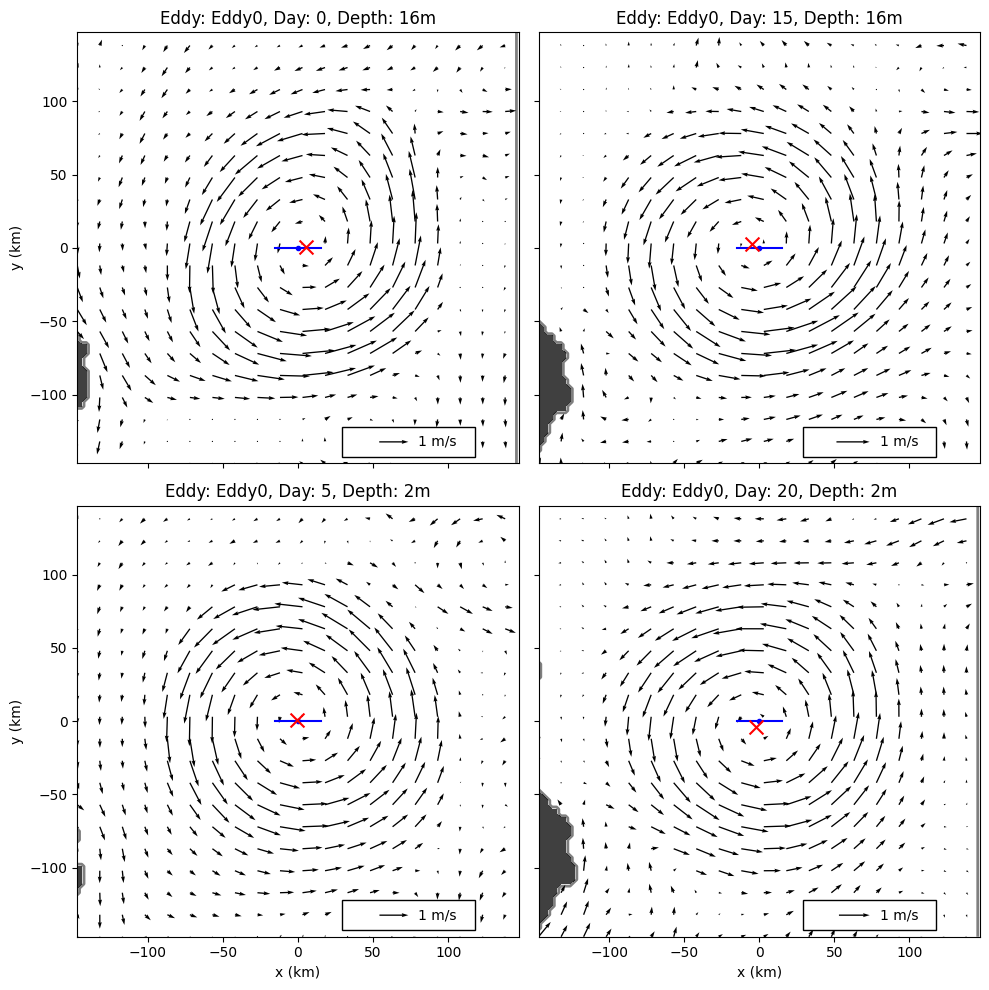

In [7]:
from matplotlib.patches import Rectangle

df_MOCA_PAPER = pd.DataFrame({
    'Eddy': ['Eddy790', 'Eddy790', 'Eddy790', 'Eddy790'],
    'Day': [0, 5, 15, 20],
    'z': [3, 0, 3, 0],
    'Method' : ['MOCA'] * 4
    })

rows, cols = 2, 2

fig, axs = plt.subplots(rows, cols, figsize=(10, 10), sharey=True, sharex=True)

for k in range(len(df_MOCA_PAPER)):

    ax = axs[k % rows, k//rows]

    df_rel = df_MOCA_PAPER.iloc[k]
    eddy, t, depth_lvl = df_rel['Eddy'], df_rel['Day'], df_rel['z']

    x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
    X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]

    u_roms = sample_data[eddy]['T'+str(t)]['U'][:, :, depth_lvl]
    v_roms = sample_data[eddy]['T'+str(t)]['V'][:, :, depth_lvl]
    
    spacing = 5
    quiv = ax.quiver(X_roms[::spacing, ::spacing], Y_roms[::spacing, ::spacing], u_roms[::spacing, ::spacing].T, v_roms[::spacing, ::spacing].T)

    df_rel = df_MOCA[(df_MOCA['Eddy']==eddy) & (df_MOCA['Day']==t) & (df_MOCA['z']==depth_lvl)]

    xc, yc, nic, njc, depth, w = df_rel['xc'], df_rel['yc'], df_rel['nic'], df_rel['njc'], df_rel['Depth'], df_rel['w']

    ax.plot(X_roms[nic, njc], Y_roms[nic, njc], marker='.', color='b')
    ax.plot([X_roms[nic, njc-r_roms], X_roms[nic, njc+r_roms]], [Y_roms[nic, njc-r_roms], Y_roms[nic, njc+r_roms]], 'b', zorder=3)
    
    ax.scatter(xc, yc, marker='x', s=100, color='r', zorder=4)

    if np.any(np.isnan(u_roms)):
        nan_mask = np.isnan(u_roms)
        mask = np.where(~np.isnan(u_roms), np.nan, 0)
        ax.contourf(X_roms, Y_roms, mask.T, cmap='gray', zorder=-1)
        ax.contour(X_roms, Y_roms, nan_mask.T, colors='k', linewidths=2, alpha=.5)

    ax.set_title(f'Eddy: Eddy{the_frontier_eddies.index(eddy)}, Day: {t}, Depth: {-round(z_r[150, 150, depth_lvl])}m')
    
    if k % rows == rows - 1:
        ax.set_xlabel('x (km)')
    if k < rows:
        ax.set_ylabel('y (km)')

    # ax.text(-0.1, 1.05, 'd)', transform=ax.transAxes, fontsize=12, fontweight='bold')

    # ax.axis('equal')

    magnitude = 1
    x_pos, y_pos = 0.75, 0.05  
    box_width = 0.3  # Adjust width as needed
    box_height = 0.07  # Adjust height as needed
    rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                           box_width, box_height, transform=ax.transAxes,
                           facecolor='white', edgecolor='black')
    ax.add_patch(rect)
    ax.quiverkey(quiv, X=x_pos, Y=y_pos, U=magnitude,
                 label=f'{magnitude} m/s', labelpos='E')

plt.tight_layout()
plt.show()

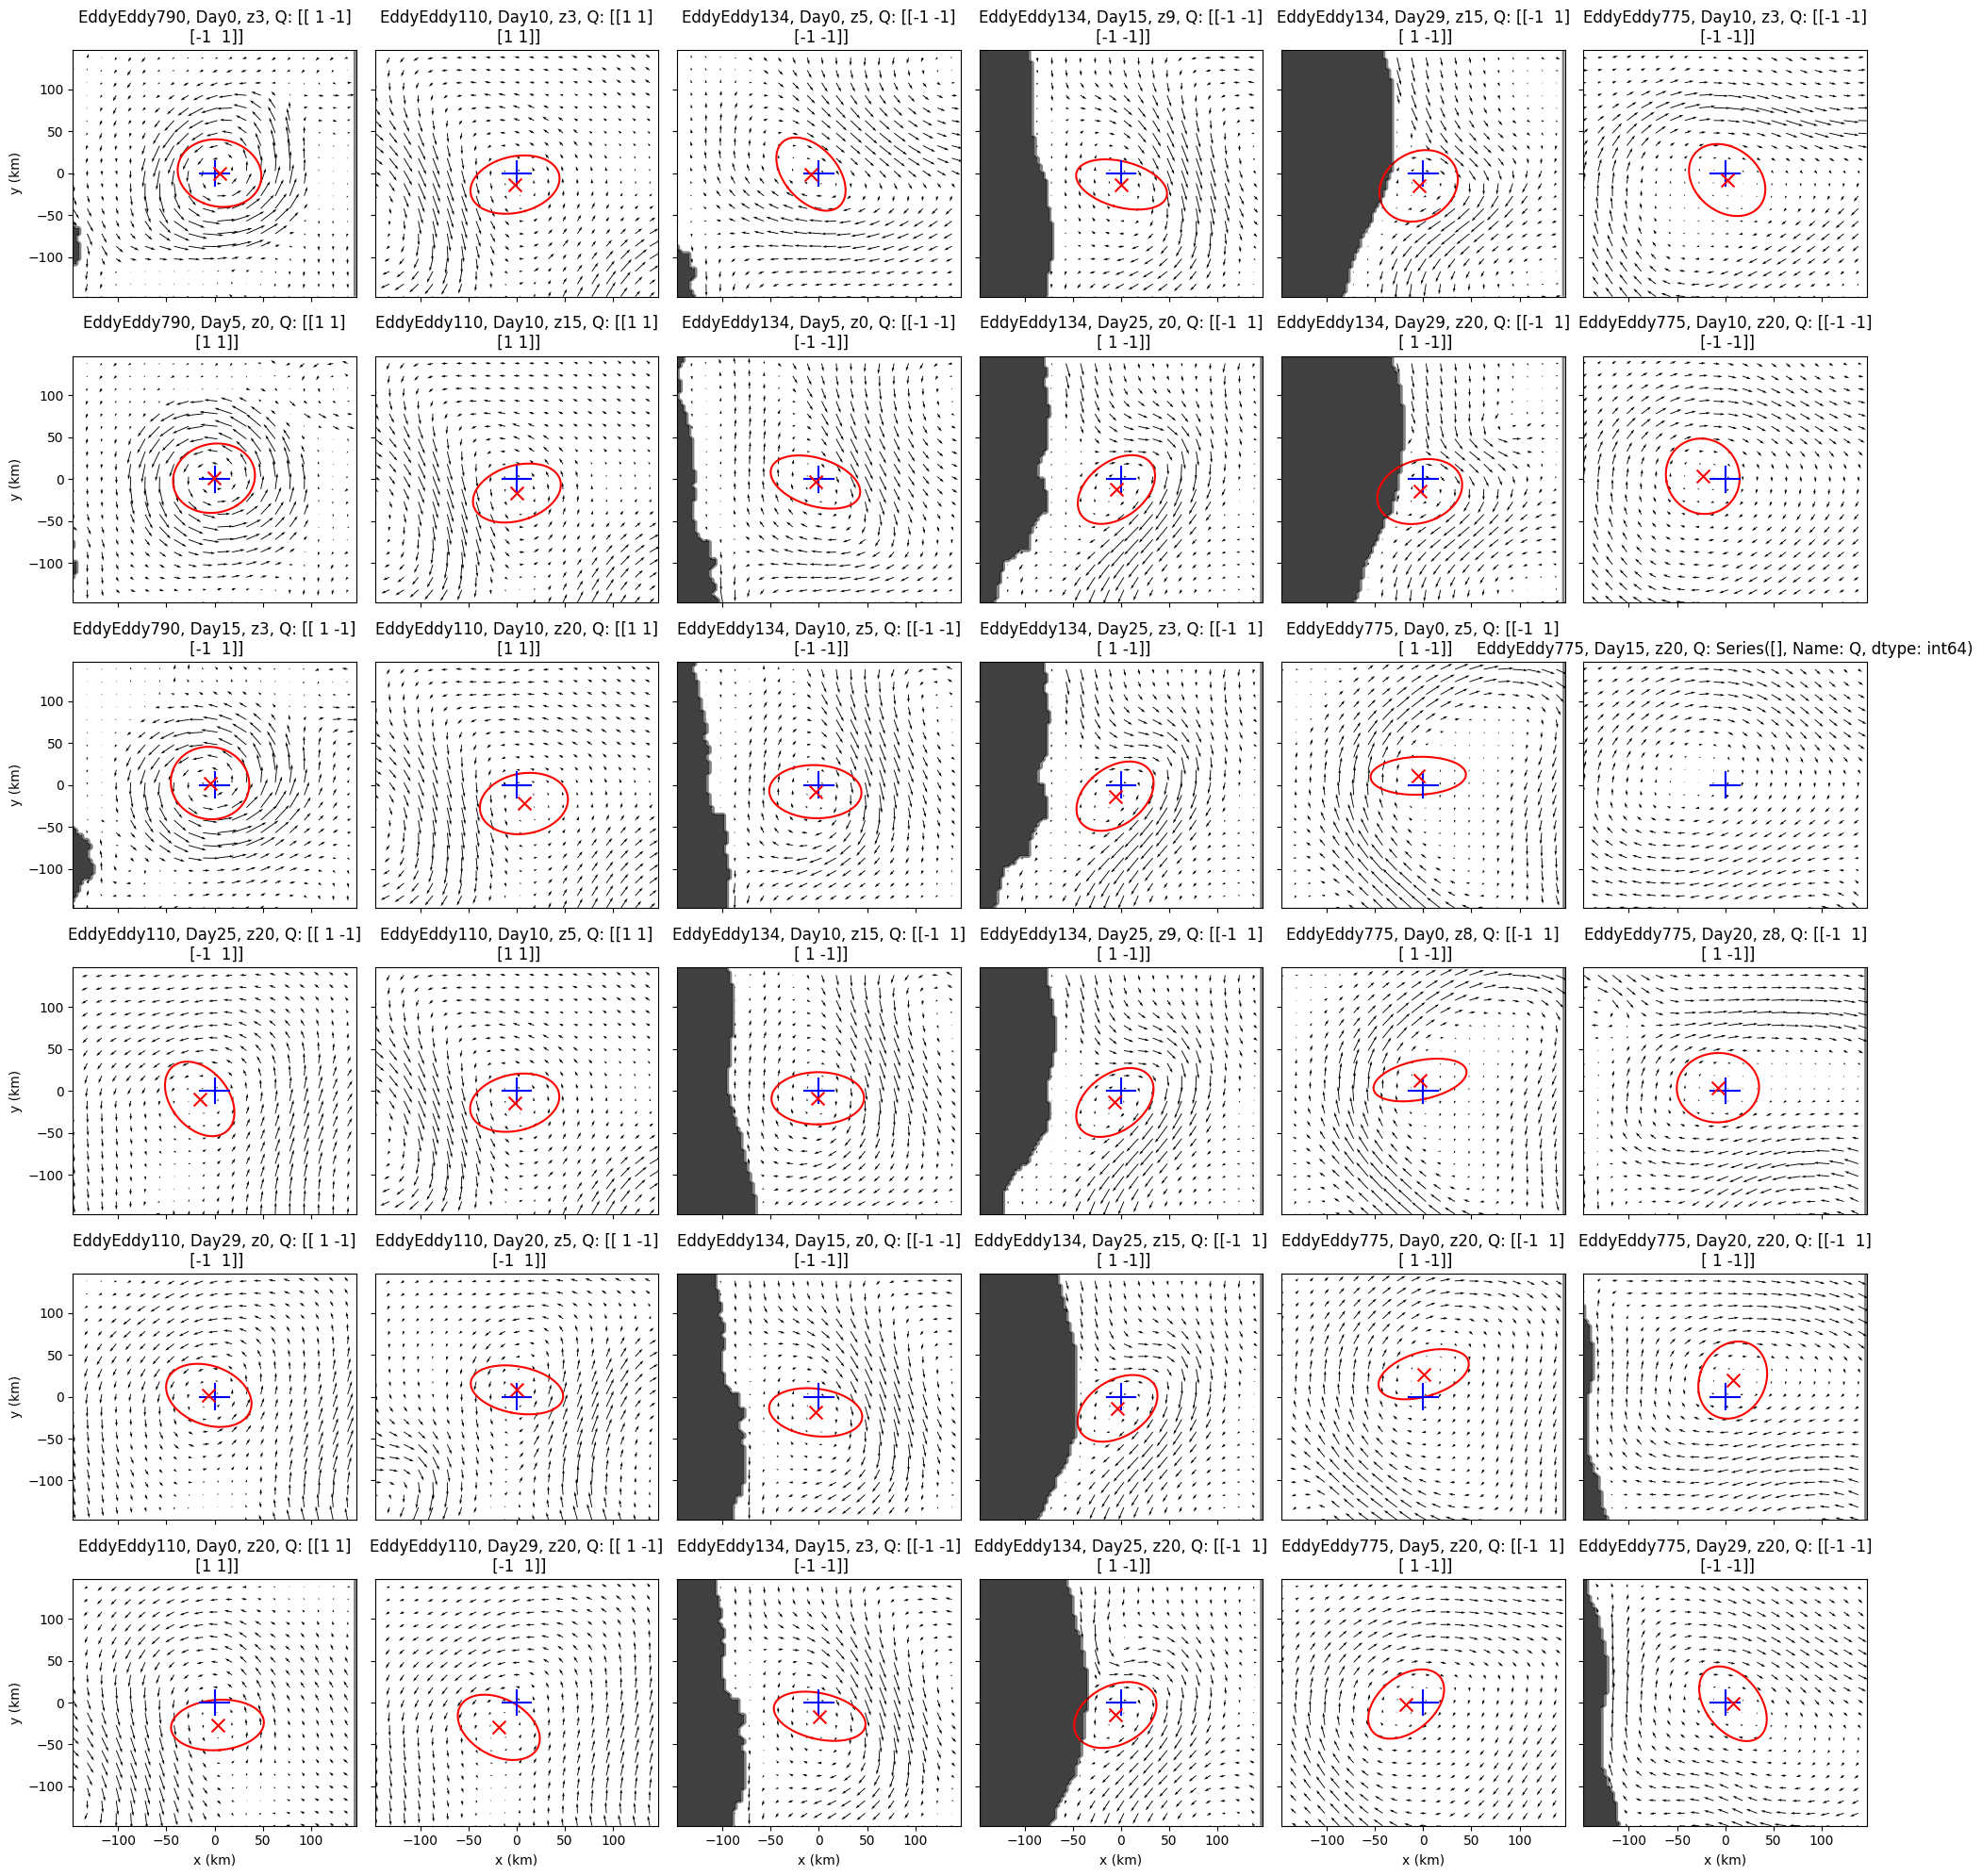

In [8]:
eddy1 = [the_frontier_eddies[0]] * 3 
t1 = [0, 5, 15, 25, 29]
z1 = [3, 0, 3, 20, 0]

eddy2 = [the_frontier_eddies[1]] * 9
t2 = [0, 10, 10, 10, 10, 20, 29]
z2 = [20, 3, 15, 20, 5, 5, 20]

eddy3 = [the_frontier_eddies[2]] * 14
t3 = [0, 5, 10, 10, 15, 15, 15, 25, 25, 25, 25, 25, 29, 29]
z3 = [5, 0, 5, 15, 0, 3, 9, 0, 3, 9, 15, 20, 15, 20]

eddy4 = [the_frontier_eddies[3]] * 10
t4 = [0, 0, 0, 5, 10, 10, 15, 20, 20, 29]
z4 = [5, 8, 20, 20, 3, 20, 20, 8, 20, 20]

df_show_offs = pd.DataFrame({
    'Eddy': eddy1 + eddy2 + eddy3 + eddy4,
    'Day': t1 + t2 + t3 + t4,
    'z': z1 + z2 + z3 + z4
    })

rows, cols = 6, 6

fig, axs = plt.subplots(rows, cols, figsize=(20, 20), sharey=True, sharex=True)

for k in range(len(df_show_offs)):

    ax = axs[k % rows, k//rows]

    df_rel = df_show_offs.iloc[k]
    eddy, t, depth_lvl = df_rel['Eddy'], df_rel['Day'], df_rel['z']

    x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
    X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]

    u_roms = sample_data[eddy]['T'+str(t)]['U'][:, :, depth_lvl]
    v_roms = sample_data[eddy]['T'+str(t)]['V'][:, :, depth_lvl]
    
    spacing = 5
    ax.quiver(X_roms[::spacing, ::spacing], Y_roms[::spacing, ::spacing], u_roms[::spacing, ::spacing].T, v_roms[::spacing, ::spacing].T)

    df_rel = df_DOPIOE[(df_DOPIOE['Eddy']==eddy) & (df_DOPIOE['Day']==t) & (df_DOPIOE['z']==depth_lvl)]

    xc, yc, nic, njc, depth, w, Q = df_rel['xc'], df_rel['yc'], df_rel['nic'], df_rel['njc'], df_rel['Depth'], df_rel['w'], df_rel['Q']

    nic, njc = 49, 49

    ax.plot([X_roms[nic-r_roms, njc], X_roms[nic+r_roms, njc]], [Y_roms[nic-r_roms, njc], Y_roms[nic+r_roms, njc]], 'b', zorder=3)
    ax.plot([X_roms[nic, njc-r_roms], X_roms[nic, njc+r_roms]], [Y_roms[nic, njc-r_roms], Y_roms[nic, njc+r_roms]], 'b', zorder=3)
    
    ax.scatter(xc, yc, marker='x', s=100, color='r', zorder=4)

    if not len(df_rel) == 0:
        Q = Q.iloc[0]
        x_ellipse, y_ellipse = plot_ellipse(Q, center=(xc, yc), scale=50)
        ax.plot(x_ellipse, y_ellipse, color='r')

    if np.any(np.isnan(u_roms)):
        nan_mask = np.isnan(u_roms)
        mask = np.where(~np.isnan(u_roms), np.nan, 0)
        ax.contourf(X_roms, Y_roms, mask.T, cmap='gray', zorder=-1)
        ax.contour(X_roms, Y_roms, nan_mask.T, colors='k', linewidths=2, alpha=.5)

    ax.set_title(f'Eddy{eddy}, Day{t}, z{depth_lvl}, Q: {np.sign(Q).astype(int)}')
    
    if k % rows == rows - 1:
        ax.set_xlabel('x (km)')
    if k < rows:
        ax.set_ylabel('y (km)')

    # ax.axis('equal')

plt.tight_layout()
plt.show()

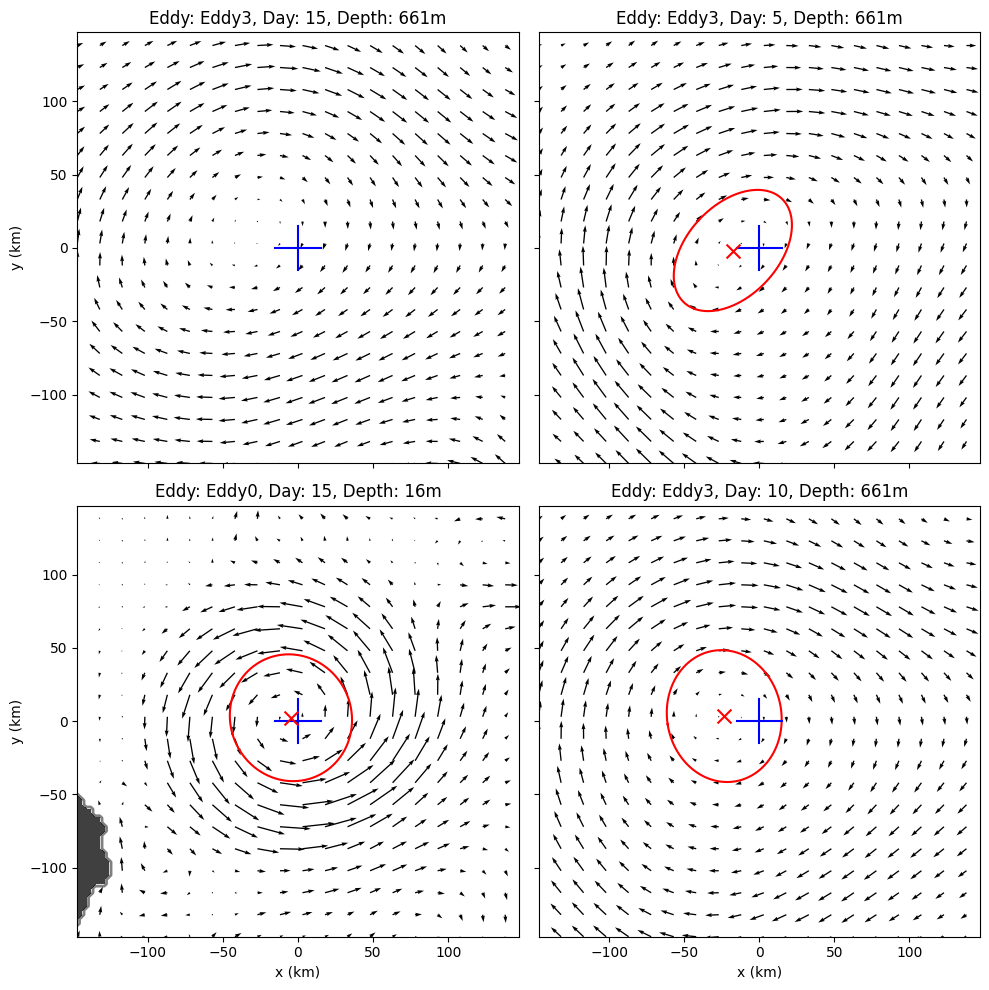

In [9]:
df_DOPIOE_PAPER = pd.DataFrame({
    'Eddy': ['Eddy775', 'Eddy790', 'Eddy775', 'Eddy775'],
    'Day': [15, 15, 5, 10],
    'z': [20, 3, 20, 20],
    'Method' : ['DOPIOE'] * 4
    })

rows, cols = 2, 2

fig, axs = plt.subplots(rows, cols, figsize=(10, 10), sharey=True, sharex=True)

for k in range(len(df_DOPIOE_PAPER)):

    ax = axs[k % rows, k//rows]

    df_rel = df_DOPIOE_PAPER.iloc[k]
    eddy, t, depth_lvl = df_rel['Eddy'], df_rel['Day'], df_rel['z']

    x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
    X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]

    u_roms = sample_data[eddy]['T'+str(t)]['U'][:, :, depth_lvl]
    v_roms = sample_data[eddy]['T'+str(t)]['V'][:, :, depth_lvl]
    
    spacing = 5
    ax.quiver(X_roms[::spacing, ::spacing], Y_roms[::spacing, ::spacing], u_roms[::spacing, ::spacing].T, v_roms[::spacing, ::spacing].T)

    df_rel = df_DOPIOE[(df_DOPIOE['Eddy']==eddy) & (df_DOPIOE['Day']==t) & (df_DOPIOE['z']==depth_lvl)]

    xc, yc, nic, njc, depth, w, Q = df_rel['xc'], df_rel['yc'], df_rel['nic'], df_rel['njc'], df_rel['Depth'], df_rel['w'], df_rel['Q']

    nic, njc = 49, 49

    ax.plot([X_roms[nic-r_roms, njc], X_roms[nic+r_roms, njc]], [Y_roms[nic-r_roms, njc], Y_roms[nic+r_roms, njc]], 'b', zorder=3)
    ax.plot([X_roms[nic, njc-r_roms], X_roms[nic, njc+r_roms]], [Y_roms[nic, njc-r_roms], Y_roms[nic, njc+r_roms]], 'b', zorder=3)
    
    ax.scatter(xc, yc, marker='x', s=100, color='r', zorder=4)

    if not len(df_rel) == 0:
        Q = Q.iloc[0]
        x_ellipse, y_ellipse = plot_ellipse(Q, center=(xc, yc), scale=50)
        ax.plot(x_ellipse, y_ellipse, color='r')

    if np.any(np.isnan(u_roms)):
        nan_mask = np.isnan(u_roms)
        mask = np.where(~np.isnan(u_roms), np.nan, 0)
        ax.contourf(X_roms, Y_roms, mask.T, cmap='gray', zorder=-1)
        ax.contour(X_roms, Y_roms, nan_mask.T, colors='k', linewidths=2, alpha=.5)

    ax.set_title(f'Eddy: Eddy{the_frontier_eddies.index(eddy)}, Day: {t}, Depth: {-round(z_r[150, 150, depth_lvl])}m')
    
    if k % rows == rows - 1:
        ax.set_xlabel('x (km)')
    if k < rows:
        ax.set_ylabel('y (km)')

    # ax.axis('equal')

plt.tight_layout()
plt.show()

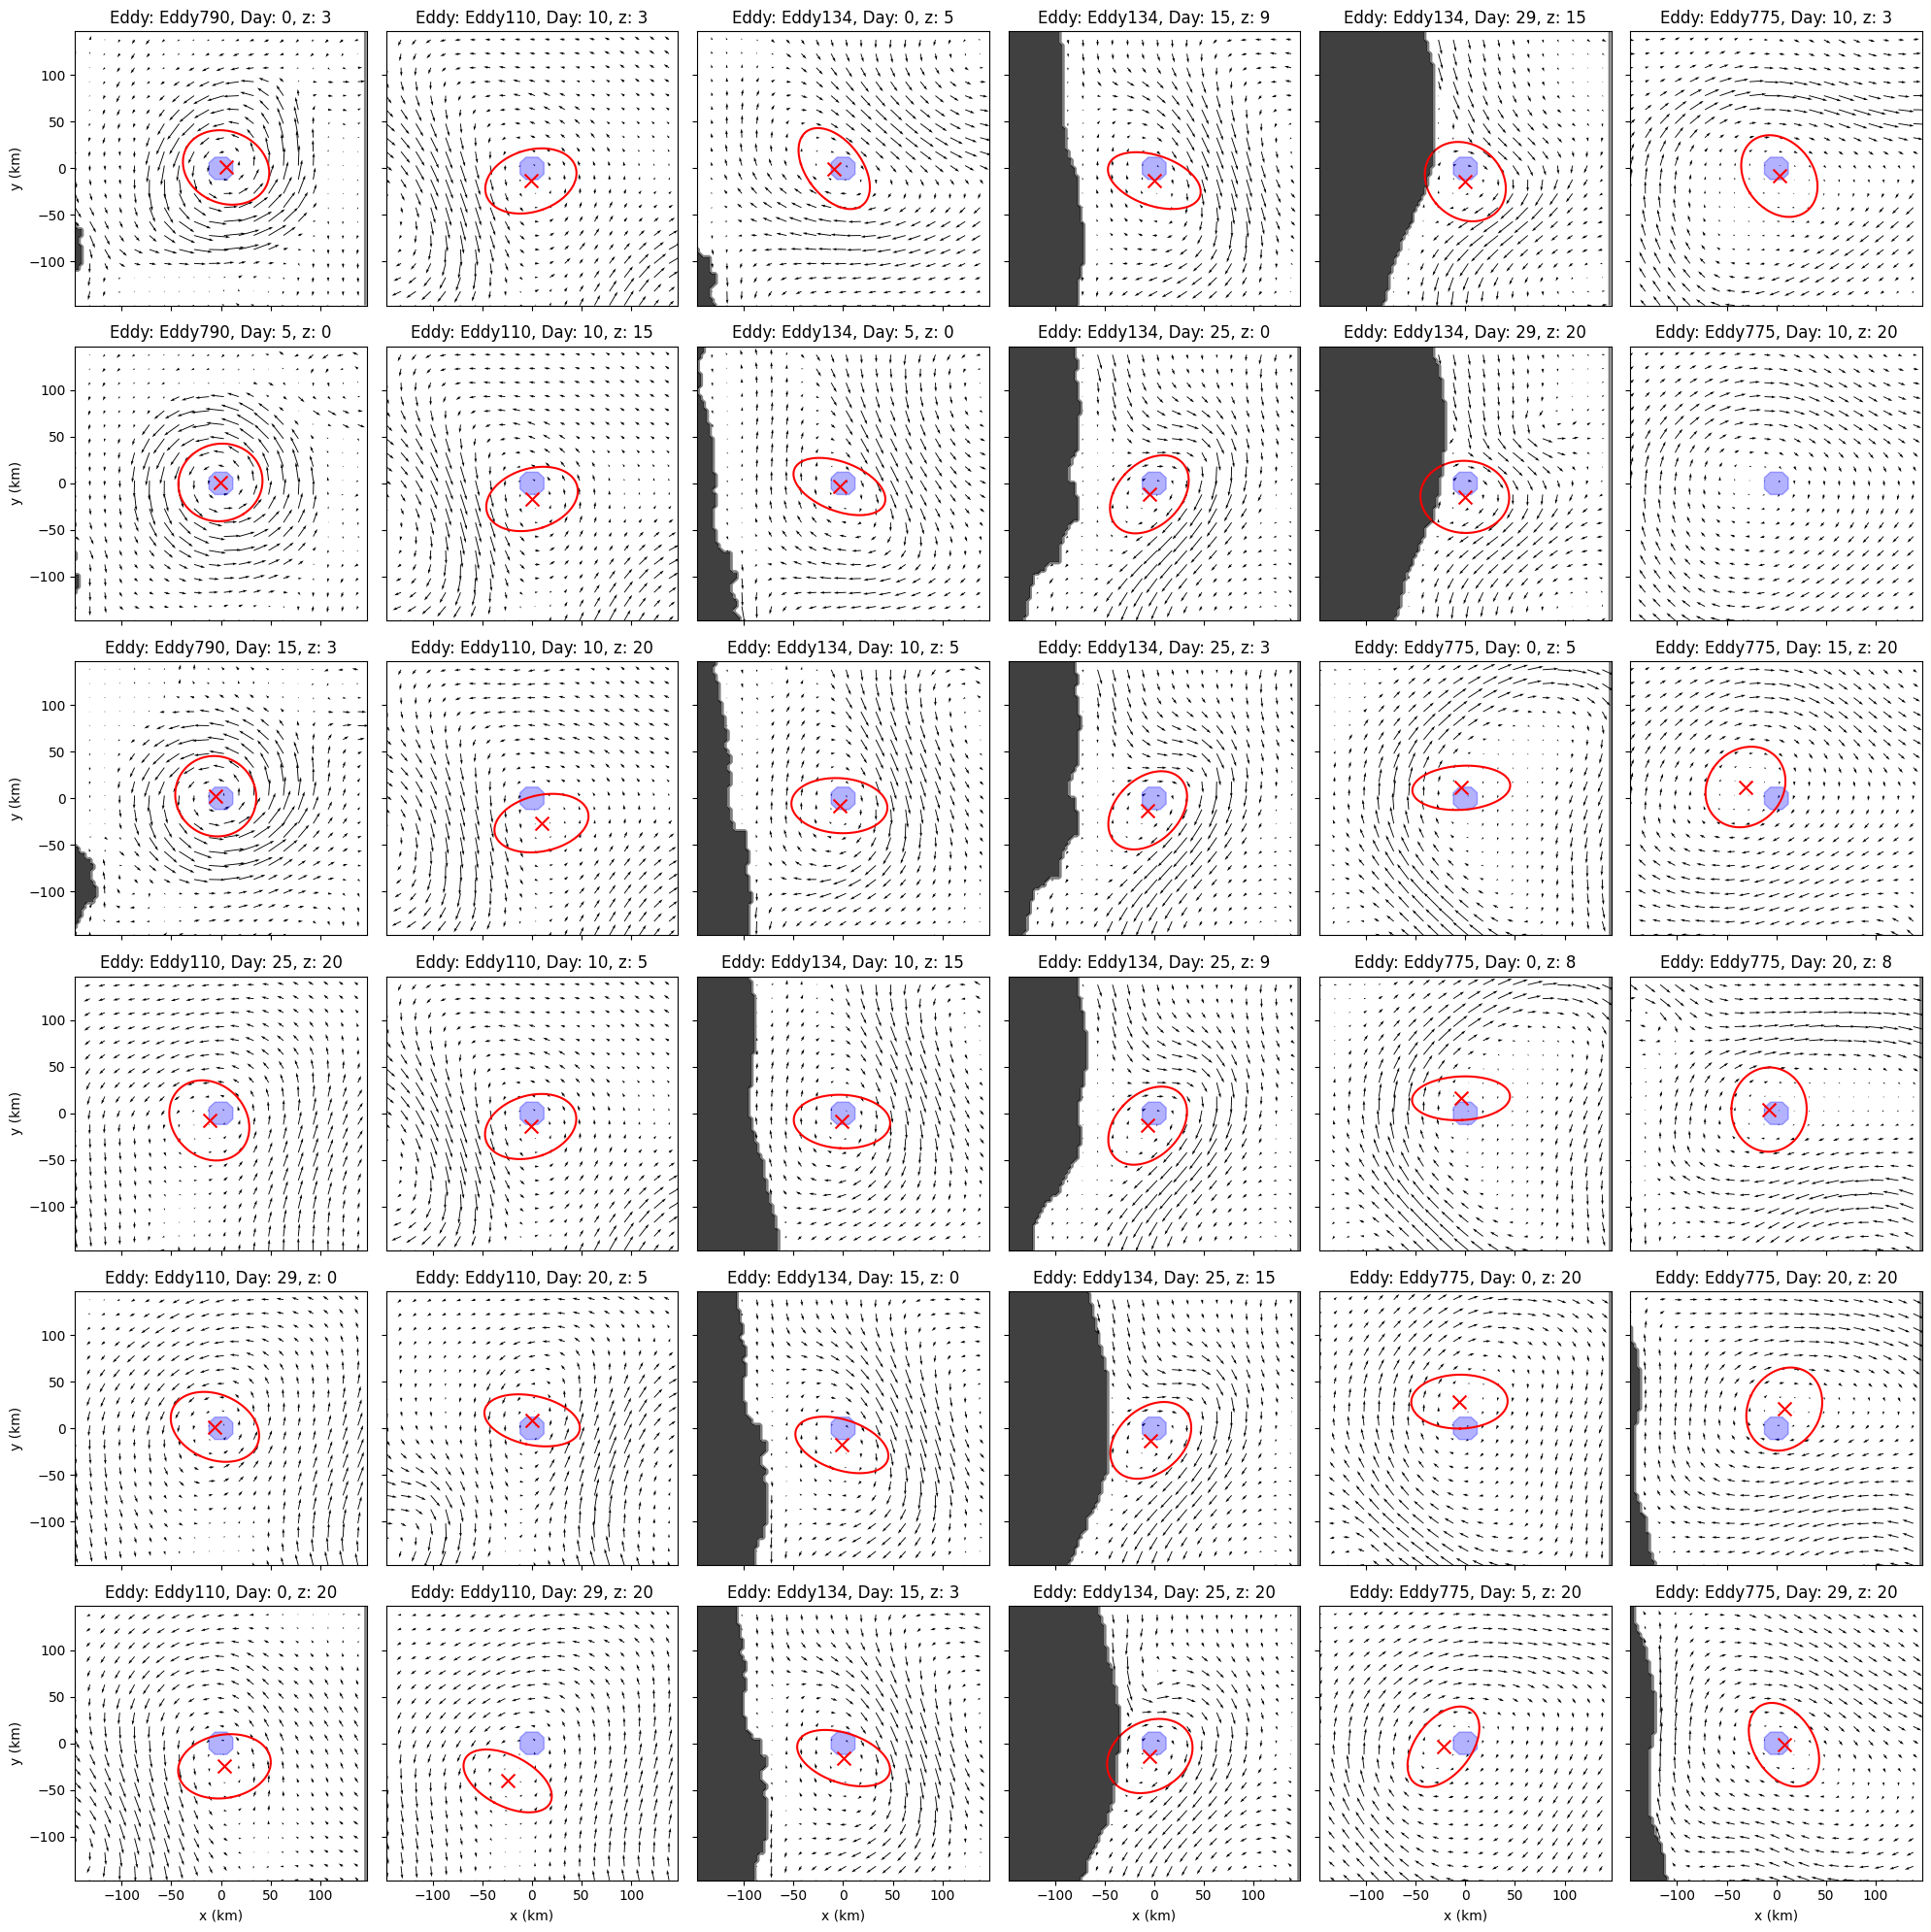

In [10]:
from scipy.spatial import ConvexHull

rows, cols = 6, 6

fig, axs = plt.subplots(rows, cols, figsize=(20, 20), sharey=True, sharex=True)

for k in range(len(df_show_offs)):

    ax = axs[k % rows, k//rows]

    df_rel = df_show_offs.iloc[k]
    eddy, t, depth_lvl = df_rel['Eddy'], df_rel['Day'], df_rel['z']

    u_roms = sample_data[eddy]['T'+str(t)]['U'][:, :, depth_lvl]
    v_roms = sample_data[eddy]['T'+str(t)]['V'][:, :, depth_lvl]

    x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
    X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]
    
    spacing = 5
    ax.quiver(X_roms[::spacing, ::spacing], Y_roms[::spacing, ::spacing], u_roms[::spacing, ::spacing].T, v_roms[::spacing, ::spacing].T)

    df_rel = df_ESPRA[(df_ESPRA['Eddy']==eddy) & (df_ESPRA['Day']==t) & (df_ESPRA['z']==depth_lvl)]

    xc, yc, nic, njc, depth, w, Q = df_rel['xc'], df_rel['yc'], df_rel['nic'], df_rel['njc'], df_rel['Depth'], df_rel['w'], df_rel['Q']

    nic, njc = 49, 49

    mask = (np.hypot(X_roms - X_roms[nic, njc], Y_roms - Y_roms[nic, njc]) < r_roms*dx_roms).T
    points = np.column_stack((X_roms[mask], Y_roms[mask]))
    
    if len(points) > 2:  # Convex hull requires at least 3 points
        hull = ConvexHull(points)
        ax.fill(points[hull.vertices, 0], points[hull.vertices, 1], color='b', alpha=0.3)

    if not len(df_rel) == 0:
        
        ax.scatter(xc, yc, marker='x', s=100, color='r', zorder=4)
        
        Q = Q.iloc[0]
        x_ellipse, y_ellipse = plot_ellipse(Q, center=(xc, yc), scale=50)
        ax.plot(x_ellipse, y_ellipse, color='r')

    if np.any(np.isnan(u_roms)):
        nan_mask = np.isnan(u_roms)
        mask = np.where(~np.isnan(u_roms), np.nan, 0)
        ax.contourf(X_roms, Y_roms, mask.T, cmap='gray', zorder=-1)
        ax.contour(X_roms, Y_roms, nan_mask.T, colors='k', linewidths=2, alpha=.5)

    ax.set_title(f'Eddy: {eddy}, Day: {t}, z: {depth_lvl}')
    
    if k % rows == rows - 1:
        ax.set_xlabel('x (km)')
    if k < rows:
        ax.set_ylabel('y (km)')

    # ax.axis('equal')

plt.tight_layout()
plt.show()

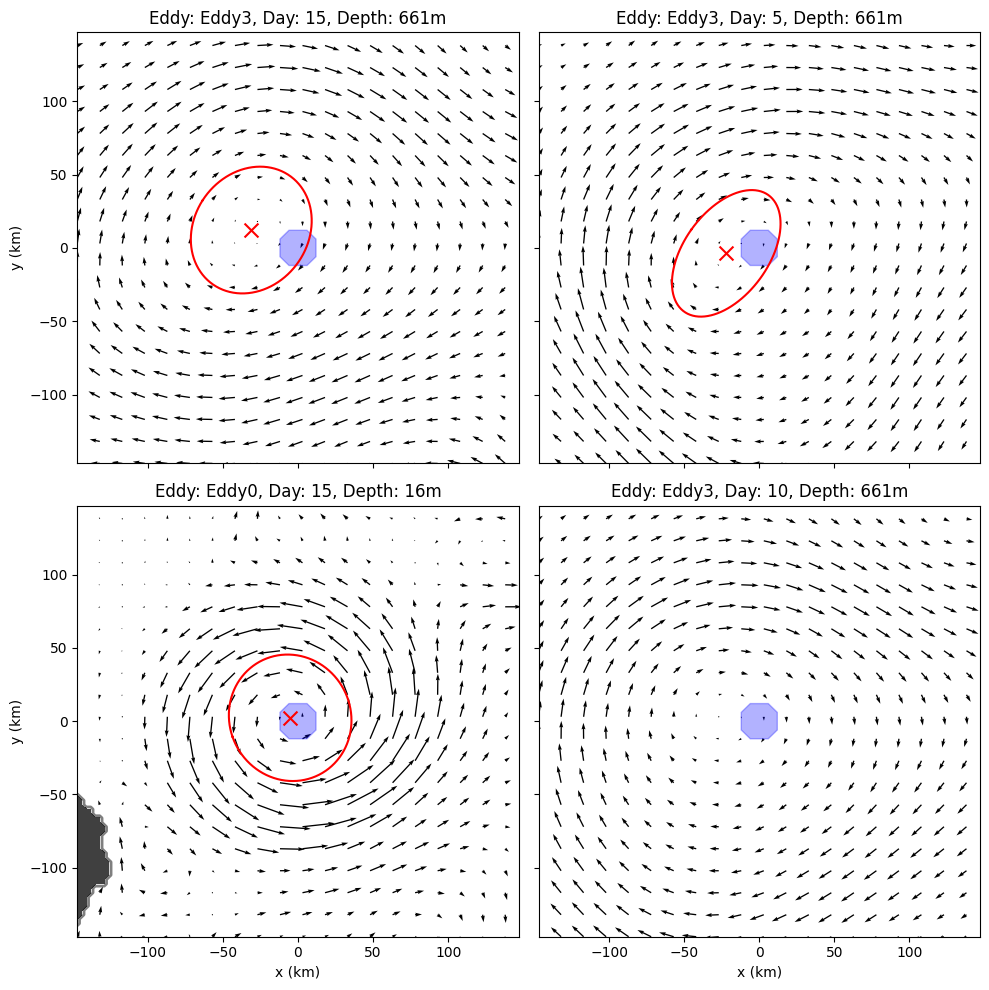

In [11]:
from scipy.spatial import ConvexHull

df_ESPRA_PAPER = pd.DataFrame({
    'Eddy': ['Eddy775', 'Eddy790', 'Eddy775', 'Eddy775'],
    'Day': [15, 15, 5, 10],
    'z': [20, 3, 20, 20],
    'Method' : ['ESPRA'] * 4
    })

rows, cols = 2, 2

fig, axs = plt.subplots(rows, cols, figsize=(10, 10), sharey=True, sharex=True)

for k in range(len(df_ESPRA_PAPER)):

    ax = axs[k % rows, k//rows]

    df_rel = df_ESPRA_PAPER.iloc[k]
    eddy, t, depth_lvl = df_rel['Eddy'], df_rel['Day'], df_rel['z']

    u_roms = sample_data[eddy]['T'+str(t)]['U'][:, :, depth_lvl]
    v_roms = sample_data[eddy]['T'+str(t)]['V'][:, :, depth_lvl]

    x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
    X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]
    
    spacing = 5
    ax.quiver(X_roms[::spacing, ::spacing], Y_roms[::spacing, ::spacing], u_roms[::spacing, ::spacing].T, v_roms[::spacing, ::spacing].T)

    df_rel = df_ESPRA[(df_ESPRA['Eddy']==eddy) & (df_ESPRA['Day']==t) & (df_ESPRA['z']==depth_lvl)]

    xc, yc, nic, njc, depth, w, Q = df_rel['xc'], df_rel['yc'], df_rel['nic'], df_rel['njc'], df_rel['Depth'], df_rel['w'], df_rel['Q']

    nic, njc = 49, 49

    mask = (np.hypot(X_roms - X_roms[nic, njc], Y_roms - Y_roms[nic, njc]) < r_roms*dx_roms).T
    points = np.column_stack((X_roms[mask], Y_roms[mask]))
    
    if len(points) > 2:  # Convex hull requires at least 3 points
        hull = ConvexHull(points)
        ax.fill(points[hull.vertices, 0], points[hull.vertices, 1], color='b', alpha=0.3)

    if not len(df_rel) == 0:
    
        ax.scatter(xc, yc, marker='x', s=100, color='r', zorder=4)

        Q = Q.iloc[0]
        x_ellipse, y_ellipse = plot_ellipse(Q, center=(xc, yc), scale=50)
        ax.plot(x_ellipse, y_ellipse, color='r')

    if np.any(np.isnan(u_roms)):
        nan_mask = np.isnan(u_roms)
        mask = np.where(~np.isnan(u_roms), np.nan, 0)
        ax.contourf(X_roms, Y_roms, mask.T, cmap='gray', zorder=-1)
        ax.contour(X_roms, Y_roms, nan_mask.T, colors='k', linewidths=2, alpha=.5)

    ax.set_title(f'Eddy: Eddy{the_frontier_eddies.index(eddy)}, Day: {t}, Depth: {-round(z_r[150, 150, depth_lvl])}m')
    
    if k % rows == rows - 1:
        ax.set_xlabel('x (km)')
    if k < rows:
        ax.set_ylabel('y (km)')

    # ax.axis('equal')

plt.tight_layout()
plt.show()

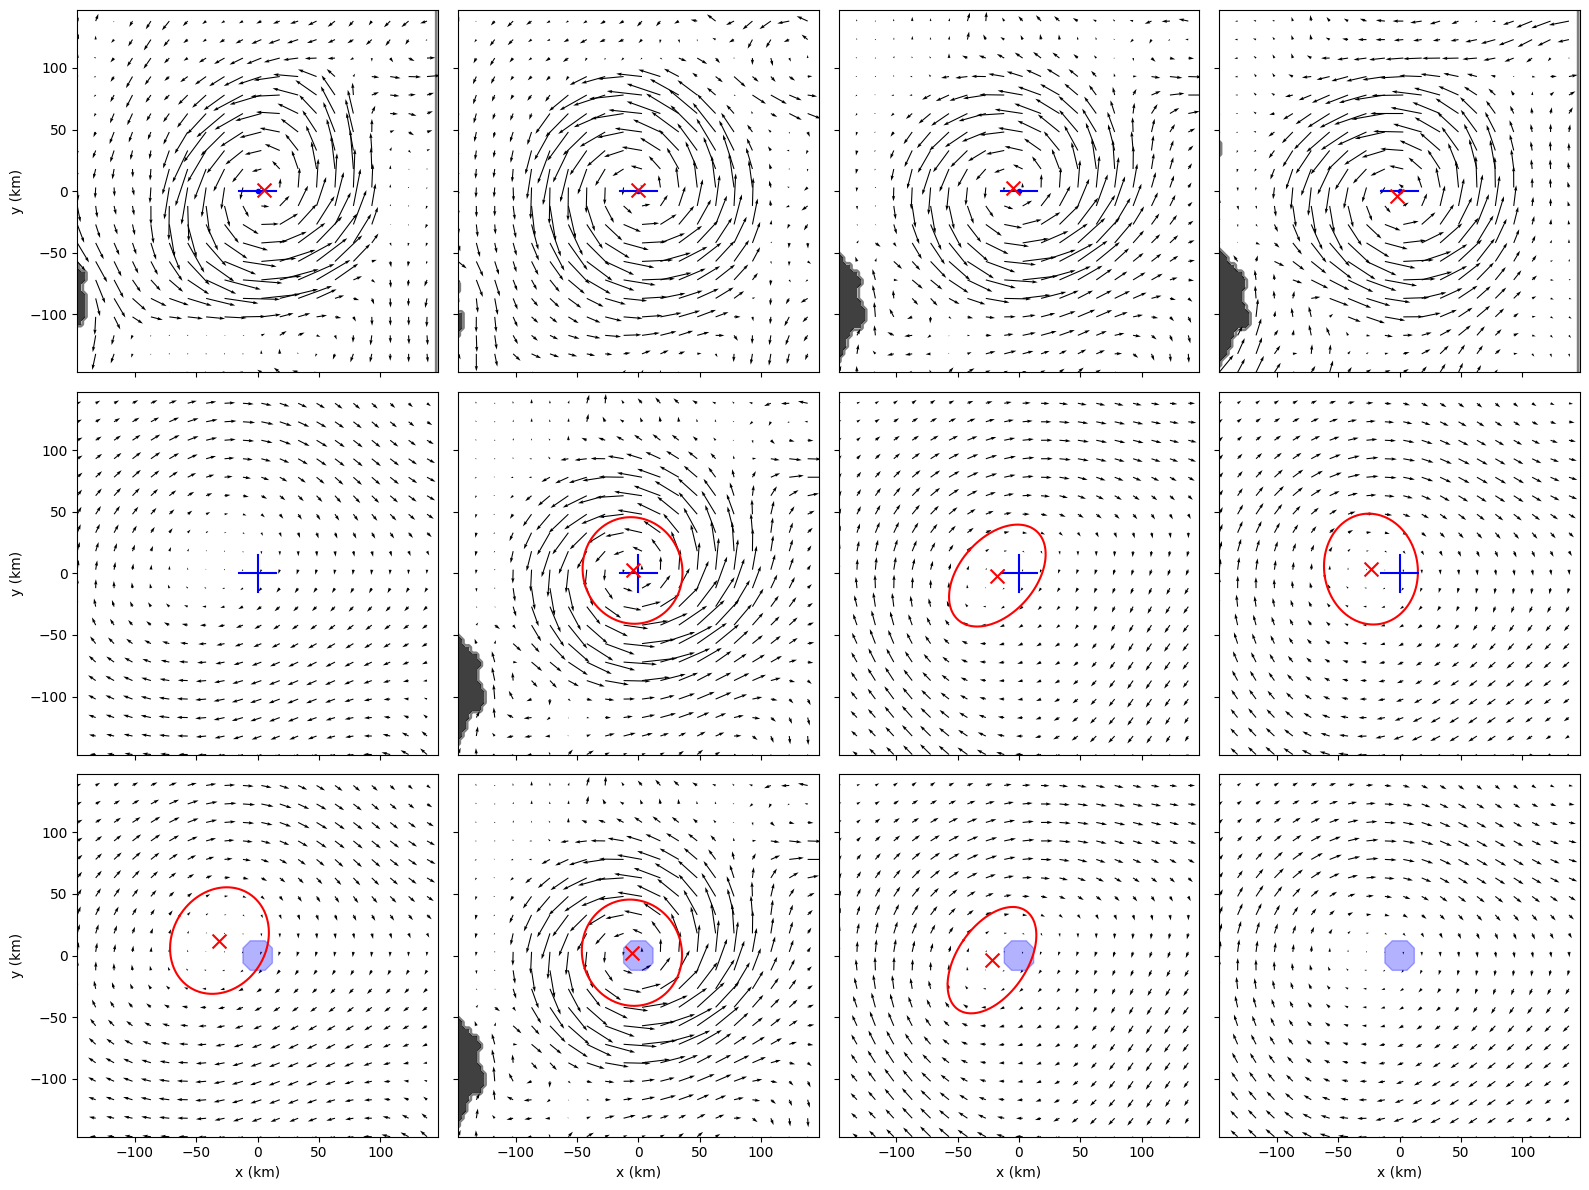

In [14]:
from matplotlib.patches import Rectangle

dfs = [df_MOCA_PAPER, df_DOPIOE_PAPER, df_ESPRA_PAPER]

rows, cols = 3, 4

scale = 10

fig, axs = plt.subplots(rows, cols, figsize=(16, 12), sharey=True, sharex=True)

for d, df in enumerate(dfs):
    
    for k in range(len(df)):
    
        ax = axs[d, k]
    
        df_rel = df.iloc[k]
        eddy, t, depth_lvl = df_rel['Eddy'], df_rel['Day'], df_rel['z']
    
        x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
        X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]
        u_roms = sample_data[eddy]['T'+str(t)]['U'][:, :, depth_lvl]
        v_roms = sample_data[eddy]['T'+str(t)]['V'][:, :, depth_lvl]
        spacing = 5
        quiv = ax.quiver(X_roms[::spacing, ::spacing], Y_roms[::spacing, ::spacing], u_roms[::spacing, ::spacing].T, v_roms[::spacing, ::spacing].T, scale=scale)
    
        if df['Method'].iloc[0] == 'MOCA':

            df_rel = df_MOCA[(df_MOCA['Eddy']==eddy) & (df_MOCA['Day']==t) & (df_MOCA['z']==depth_lvl)]
        
            xc, yc, nic, njc, depth, w = df_rel['xc'], df_rel['yc'], df_rel['nic'], df_rel['njc'], df_rel['Depth'], df_rel['w']
        
            ax.plot(X_roms[nic, njc], Y_roms[nic, njc], marker='.', color='b')
            ax.plot([X_roms[nic, njc-r_roms], X_roms[nic, njc+r_roms]], [Y_roms[nic, njc-r_roms], Y_roms[nic, njc+r_roms]], 'b', zorder=3)
            
            ax.scatter(xc, yc, marker='x', s=100, color='r', zorder=4)
        
        if df['Method'].iloc[0] == 'DOPIOE':

            df_rel = df_DOPIOE[(df_DOPIOE['Eddy']==eddy) & (df_DOPIOE['Day']==t) & (df_DOPIOE['z']==depth_lvl)]
    
            xc, yc, nic, njc, depth, w, Q = df_rel['xc'], df_rel['yc'], df_rel['nic'], df_rel['njc'], df_rel['Depth'], df_rel['w'], df_rel['Q']

            nic, njc = 49, 49
            
            ax.plot([X_roms[nic-r_roms, njc], X_roms[nic+r_roms, njc]], [Y_roms[nic-r_roms, njc], Y_roms[nic+r_roms, njc]], 'b', zorder=3)
            ax.plot([X_roms[nic, njc-r_roms], X_roms[nic, njc+r_roms]], [Y_roms[nic, njc-r_roms], Y_roms[nic, njc+r_roms]], 'b', zorder=3)

            if not len(df_rel) == 0:
                ax.scatter(xc, yc, marker='x', s=100, color='r', zorder=4)

                Q = Q.iloc[0]
                x_ellipse, y_ellipse = plot_ellipse(Q, center=(xc, yc), scale=50)
                ax.plot(x_ellipse, y_ellipse, color='r')

        if df['Method'].iloc[0] == 'ESPRA':

            df_rel = df_ESPRA[(df_ESPRA['Eddy']==eddy) & (df_ESPRA['Day']==t) & (df_ESPRA['z']==depth_lvl)]

            xc, yc, nic, njc, depth, w, Q = df_rel['xc'], df_rel['yc'], df_rel['nic'], df_rel['njc'], df_rel['Depth'], df_rel['w'], df_rel['Q']
            
            nic, njc = 49, 49

            mask = (np.hypot(X_roms - X_roms[nic, njc], Y_roms - Y_roms[nic, njc]) < r_roms*dx_roms).T
            points = np.column_stack((X_roms[mask], Y_roms[mask]))
            
            if len(points) > 2:  # Convex hull requires at least 3 points
                hull = ConvexHull(points)
                ax.fill(points[hull.vertices, 0], points[hull.vertices, 1], color='b', alpha=0.3)

            if not len(df_rel) == 0:

                ax.scatter(xc, yc, marker='x', s=100, color='r', zorder=4)

                Q = Q.iloc[0]
                x_ellipse, y_ellipse = plot_ellipse(Q, center=(xc, yc), scale=50)
                ax.plot(x_ellipse, y_ellipse, color='r')
        
        if np.any(np.isnan(u_roms)):
            nan_mask = np.isnan(u_roms)
            mask = np.where(~np.isnan(u_roms), np.nan, 0)
            ax.contourf(X_roms, Y_roms, mask.T, cmap='gray', zorder=-1)
            ax.contour(X_roms, Y_roms, nan_mask.T, colors='k', linewidths=2, alpha=.5)
    
        # ax.set_title(f'Eddy: Eddy{the_frontier_eddies.index(eddy)}, Day: {t}, Depth: {-round(z_r[150, 150, depth_lvl])}m')
        
        if d == rows - 1:
            ax.set_xlabel('x (km)')
        if k == 0:
            ax.set_ylabel('y (km)')
    
        # ax.text(-0.1, 1.05, 'd)', transform=ax.transAxes, fontsize=12, fontweight='bold')
    
        # ax.axis('equal')
    
        # magnitude = 1
        # x_pos, y_pos = 0.75, 0.05  
        # box_width = 0.3  # Adjust width as needed
        # box_height = 0.07  # Adjust height as needed
        # rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
        #                        box_width, box_height, transform=ax.transAxes,
        #                        facecolor='white', edgecolor='black')
        # ax.add_patch(rect)
        # ax.quiverkey(quiv, X=x_pos, Y=y_pos, U=magnitude,
        #              label=f'{magnitude} m/s', labelpos='E')

plt.tight_layout()
plt.show()